In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 32

In [3]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

model_dict_3 = {}
for k,v in model_dictionary.items():
  if k == 'MobileNetV2':
    model_dict_3['MobileNetV2'] = v

  if k == 'DenseNet121':
    model_dict_3['DenseNet121'] = v

  if k == 'VGG16':
    model_dict_3['VGG16'] = v
model_dict_1 = {}
for k,v in model_dictionary.items():
  if k == 'MobileNetV2':
    model_dict_1['MobileNetV2'] = v
model_dictionary = model_dict_1
print(model_dictionary)

{'MobileNetV2': <function MobileNetV2 at 0x7f62d3989dd0>}


In [4]:
(train, validation), metadata = tfds.load('cifar10', split=['train[:70%]', 'train[70%:]'], 
                                          with_info=True, as_supervised=True)

# Number of training examples and labels
num_train = len(list(train))
num_validation = len(list(validation))
num_classes = len(metadata.features['label'].names)
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete6JO6Q5/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete6JO6Q5/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Num train images: 35000         
Num validation images: 15000         
Num classes: 10         
Num iterations per epoch: 1093


In [5]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    train_processed = train_processed.batch(batch_size).repeat()

    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    validation_processed = validation_processed.batch(batch_size)

    return train_processed, validation_processed

# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])

In [6]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
input_shape = (224,224,3)
train_processed = train_processed_224
validation_processed = validation_processed_224
for model_name, model in tqdm(model_dictionary.items()):
  # Feature extraction
  # load the pre-trained model with global average pooling as the last layer and freeze the model weights
  pre_trained_model = model(include_top=False, pooling='max', input_shape=input_shape)
  pre_trained_model.trainable = False

  # custom modifications on top of pre-trained model
  clf_model = tf.keras.models.Sequential()
  clf_model.add(pre_trained_model)
  clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
  history_ft_extract = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, 
                          steps_per_epoch=num_iterations)
  

  # Fine_tunnig
  pre_trained_model.trainable = True

  print("Number of layers in the base model: ", len(pre_trained_model.layers))


# Fine-tune from this layer onwards
  fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
  for layer in pre_trained_model.layers[:fine_tune_at]:
    layer.trainable =  False

  clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

  history_fine = clf_model.fit(train_processed, initial_epoch=history_ft_extract.epoch[-1], epochs=6, validation_data=validation_processed, 
                          steps_per_epoch=num_iterations)  


  # Calculate all relevant metrics
  model_benchmarks['model_name'].append(model_name)
  model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
  model_benchmarks['validation_accuracy'].append((history_ft_extract['val_accuracy'][-1]+history_fine['val_accuracy'][-1])/2)

  0%|          | 0/1 [00:00<?, ?it/s]

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
   1/1093 [..............................] - ETA: 1:13:18 - loss: 10.1628 - accuracy: 0.1250

  0%|          | 0/1 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

In [6]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df

,model_name,num_model_params,validation_accuracy
1,MobileNetV2,2257984,0.8060
0,DenseNet121,7037504,0.8184
2,VGG16,14714688,0.5128


In [7]:
markers=["H","X","D"]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot

NameError: ignored

<Figure size 504x360 with 0 Axes>

In [8]:
def plot_accuracy(history,h2=None):
    if (h2):
        plt.plot(history.history['accuracy']+h2.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy']+h2.history['val_accuracy'], label = 'val_accuracy')
    else:
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
def plot_loss(history,h2=None):
    if (h2):
        plt.plot(history.history['loss']+h2.history['loss'], label='loss')
        plt.plot(history.history['val_loss']+h2.history['val_loss'], label = 'val_loss')
    else:
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

In [9]:
#Now we will compare Ft_extraction to Fine tunning with MobileNetV2 

pre_trained_model = model_dict_1['MobileNetV2'](include_top=False, pooling='max', input_shape=input_shape)

pre_trained_model.trainable = False

# custom modifications on top of pre-trained model
clf_model = tf.keras.models.Sequential()
clf_model.add(pre_trained_model)
clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history_ft_extract = clf_model.fit(train_processed, epochs=10, validation_data=validation_processed, 
                          steps_per_epoch=num_iterations)

ft_model = tf.keras.models.Sequential()
ft_model.add(pre_trained_model)
ft_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

pre_trained_model.trainable = True



# Fine-tune from this layer onwards
fine_tune_at = 370

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable =  False

clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_plus = clf_model.fit(train_processed, initial_epoch=history_ft_extract.epoch[-1], epochs=20, validation_data=validation_processed, 
                          steps_per_epoch=num_iterations)






Epoch 1/10
1093/1093 [==============================] - ETA: 0s - loss: 1.6881 - accuracy: 0.6375

KeyboardInterrupt: ignored

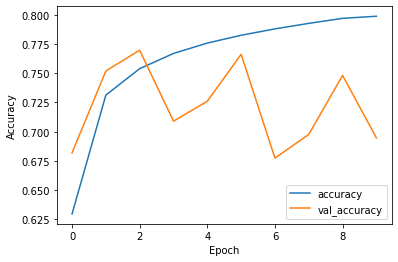

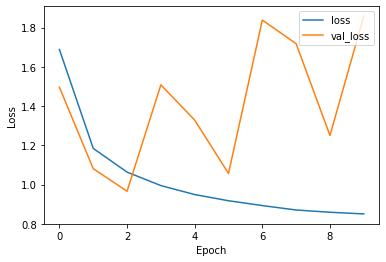

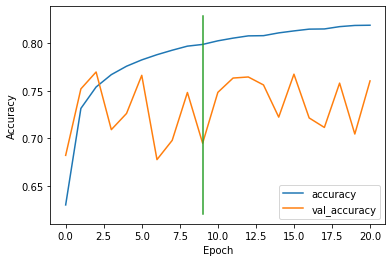

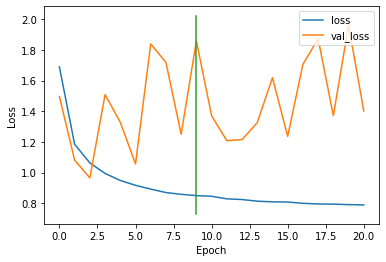

In [20]:
plot_accuracy(history_ft_extract,None)
plt.show()
plot_loss(history_ft_extract,None)
plt.show()



plot_accuracy(history_ft_extract,history_fine_plus)
plt.plot([9,9],plt.ylim(), label='Start Fine Tuning')
plt.show()
plot_loss(history_ft_extract,history_fine_plus)
plt.plot([9,9],plt.ylim(), label='Start Fine Tuning')
plt.show()

